In [2]:
from pathlib import Path

from pyspark.sql.session import SparkSession
from pyspark.sql import DataFrame

MAX_MEMORY = "5g"
spark = (
    SparkSession.builder.master("local[*]")
    .appName("TripAnaliysis")
    .config("spark.excutor.memory", MAX_MEMORY)
    .config("spark.driver.memory", MAX_MEMORY)
    .getOrCreate()
)

24/02/17 17:25:13 WARN Utils: Your hostname, limhaneul-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.81 instead (on interface en0)
24/02/17 17:25:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/02/17 17:25:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import os

def read_parquet_data(year: int) -> list[DataFrame]:
    # 모든 파케이 파일 경로
    def parquet_file_all() -> list[str]:
        return sorted(list(Path(os.getcwd()).joinpath(f"data/{str(year)}").glob("*")))
        
    return [spark.read.parquet(f"file:///{data}") for data in parquet_file_all()]

In [329]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

data = read_parquet_data(2019)[1]

In [353]:

from pyspark.sql.types import DateType
from pyspark.sql import Column

def datetime_groupby(name: str, agg_name: str) -> DataFrame:
    return (
        data.select(F.split(col(name), " ")[0].name("pickup"))
        .groupBy("pickup")
        .agg(F.count("*").name(agg_name))
    )


def datetime_miles_average() -> DataFrame:
    return (data.select(F.split(col("pickup_datetime"), " ")[0].name("pickup"), col("trip_miles")) 
        .groupBy("pickup") 
        .agg(F.count("pickup").name("pickup_total"), F.avg("trip_miles").name("average_miles")) 
    )

def to_null_date(value: Column) -> Column:
    return F.when(value.isNull(), F.lit("2019-02-20")).otherwise(value.cast(DateType()))


In [331]:

request_groupby = datetime_groupby("request_datetime", "request_count").withColumn("pickup", to_null_date(col("pickup")))
trip_groupby = datetime_groupby("pickup_datetime", "trip_count")
drop_groupby = datetime_groupby("dropoff_datetime", "drop_count")
average_mile = datetime_miles_average()


    #  AnalysisException: Column 'pickup' does not exist. Did you mean one of the following? [week, week_number];

rtd_join = (
    trip_groupby
    .join(request_groupby, on="pickup")
    .join(drop_groupby, on="pickup")
    .join(average_mile, on="pickup")
).orderBy("pickup")

week_day_rtd_join = (
    rtd_join.select(
        F.date_format(col("pickup"), "EEEE").alias("week"),
        col("pickup"), 
        col("trip_count"), 
        col("request_count"), 
        col("drop_count"),
        col("average_miles")
    )
).toPandas()

In [349]:

import matplotlib.pyplot as plt 
import seaborn as sns

week_day_rtd_join.to_csv("test.csv", index=False)
group_date = week_day_rtd_join.groupby("week").average_miles.mean().to_frame().reset_index()
group_date["sort_dow"] = group_date["week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,  
})


,week,average_miles,sort_dow
3,Sunday,4.675137,0
1,Monday,4.889773,1
5,Tuesday,4.689844,2
6,Wednesday,4.631984,3
4,Thursday,4.660390,4
0,Friday,4.723160,5
2,Saturday,4.653826,6


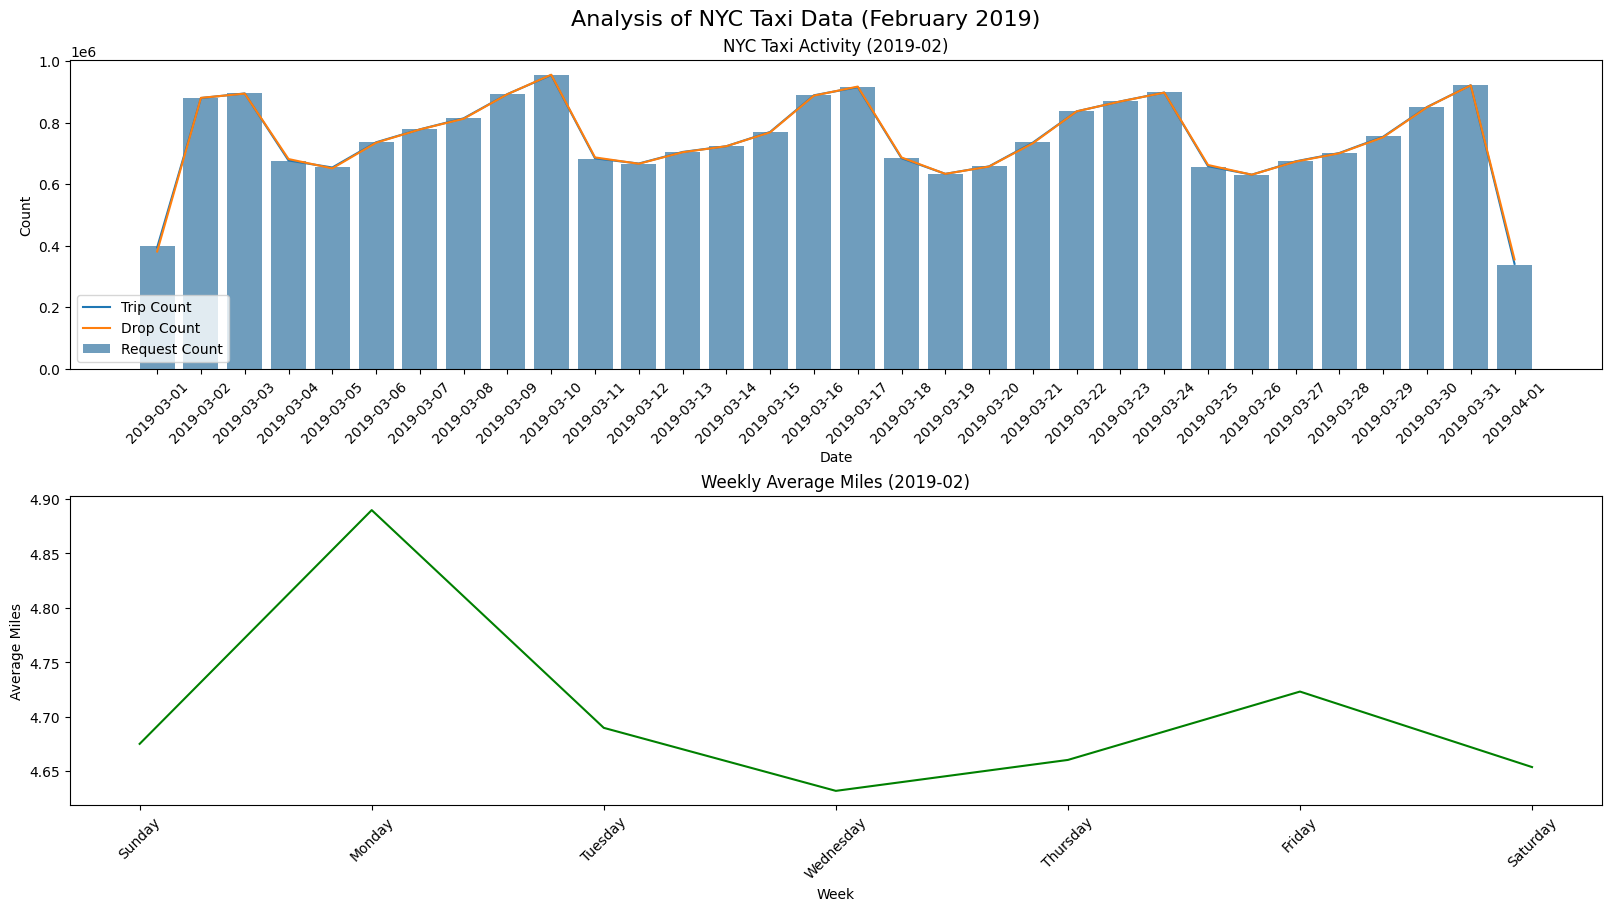

In [352]:

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(16, 9), constrained_layout=True)

# Plot 1: Pickup, trip_count, request_count, and drop_count
sns.lineplot(x="pickup", y="trip_count", data=week_day_rtd_join, ax=ax[0], label="Trip Count")
sns.barplot(x="pickup", y="request_count", data=week_day_rtd_join, ax=ax[0], alpha=0.7, label="Request Count")
sns.lineplot(x="pickup", y="drop_count", data=week_day_rtd_join, ax=ax[0], label="Drop Count")
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Count")
ax[0].legend()
ax[0].set_title("NYC Taxi Activity (2019-02)")

# Plot 2: Weekly average miles
sns.lineplot(x="week", y="average_miles", data=group_date.sort_values("sort_dow"), ax=ax[1], color='green')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Week")
ax[1].set_ylabel("Average Miles")
ax[1].set_title("Weekly Average Miles (2019-02)")

# Overall Title
plt.suptitle("Analysis of NYC Taxi Data (February 2019)", fontsize=16)

# Show plot
plt.show()

In [334]:
group_date

,week,average_miles,sort_dow
0,Friday,4.723160,5
1,Monday,4.889773,1
2,Saturday,4.653826,6
3,Sunday,4.675137,0
4,Thursday,4.660390,4
5,Tuesday,4.689844,2
6,Wednesday,4.631984,3
